# Run file
features combination 2 : 
11h00 - jsp - log csv marche pas je crois

/home/deepL_project/functions.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


✅ Resumed from epoch 1
📚 Epoch 2: Train Loss = 0.8506, Val Loss = 0.8921
📚 Epoch 3: Train Loss = 0.7966, Val Loss = 0.8858
📚 Epoch 4: Train Loss = 0.7612, Val Loss = 0.9041
📚 Epoch 5: Train Loss = 0.7339, Val Loss = 0.9059
📚 Epoch 6: Train Loss = 0.7137, Val Loss = 0.9165


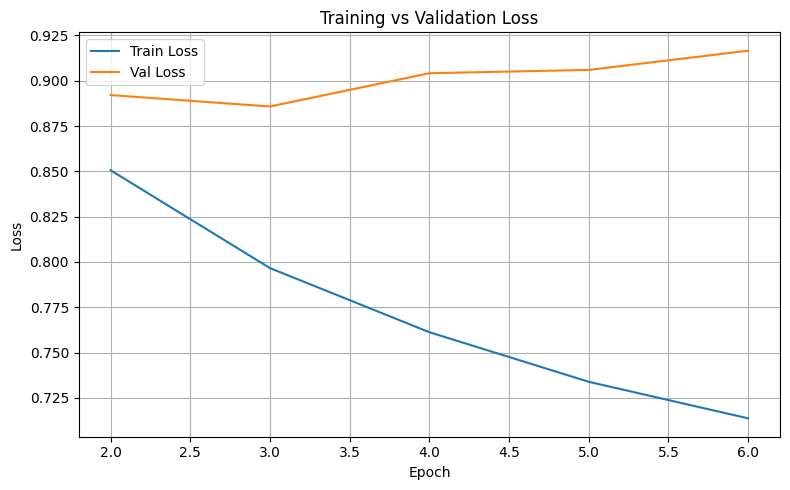


 Final Evaluation on TEST set:

📊 Regression (Numerical):
• R² Score: 0.5108
• MSE: 0.7194

⚖️ Classification (Binary):
• Accuracy: 0.6915
• F1 Macro: 0.8042
• F1 Micro: 0.8122


In [1]:
# === FILE RUN : uses function.py  ===

import torch
import torch.nn as nn
from transformers import AutoTokenizer
from torch.utils.data import DataLoader
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from functions import train_with_checkpoint, train_with_logging, compute_scores, evaluate
import os

# === Load data ===
df = pd.read_parquet("data/measuring-hate-speech.parquet")
df = df.dropna(subset=['text'])

numerical_cols = ['sentiment', 'respect', 'insult', 'humiliate', 'status',
                  'dehumanize', 'attack_defend', 'hatespeech']
binary_cols = ['target_race', 'target_religion', 'target_origin', 'target_gender',
               'target_sexuality']

df[binary_cols] = df[binary_cols].astype(int)

# === Split into train/val/test ===
train_texts, temp_texts, train_y_num, temp_y_num, train_y_bin, temp_y_bin = train_test_split(
    df['text'], df[numerical_cols], df[binary_cols], test_size=0.3, random_state=42
)
val_texts, test_texts, val_y_num, test_y_num, val_y_bin, test_y_bin = train_test_split(
    temp_texts, temp_y_num, temp_y_bin, test_size=1/3, random_state=42
)

# === Tokenization ===
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

class HateSpeechDataset(torch.utils.data.Dataset):
    def __init__(self, texts, targets_num, targets_bin, tokenizer, max_len=128):
        self.texts = list(texts)
        self.targets_num = torch.tensor(targets_num.values, dtype=torch.float)
        self.targets_bin = torch.tensor(targets_bin.values, dtype=torch.float)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'num_targets': self.targets_num[idx],
            'bin_targets': self.targets_bin[idx]
        }

# === DataLoaders ===
train_ds = HateSpeechDataset(train_texts, train_y_num, train_y_bin, tokenizer)
val_ds = HateSpeechDataset(val_texts, val_y_num, val_y_bin, tokenizer)
test_ds = HateSpeechDataset(test_texts, test_y_num, test_y_bin, tokenizer)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)
test_loader = DataLoader(test_ds, batch_size=16)

# === Define model ===
from transformers import AutoModel
class BERTMultiTaskModel(nn.Module):
    def __init__(self, model_name="distilbert-base-uncased", num_outputs=8, bin_outputs=5):      #change number if different set of features
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        hidden_size = self.bert.config.hidden_size
        self.regressor = nn.Sequential(
            nn.Linear(hidden_size, 128),
            nn.ReLU(),
            nn.Linear(128, num_outputs)
        )
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Linear(64, bin_outputs),
            nn.Sigmoid()
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.last_hidden_state[:, 0]
        return self.regressor(pooled), self.classifier(pooled)

# === Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTMultiTaskModel().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn_num = nn.MSELoss()
loss_fn_bin = nn.BCELoss()

# === Train ===
#checkpoint_path = "checkpoint.pt"

'''
train_with_checkpoint(
    model, optimizer,
    train_loader, val_loader,
    loss_fn_num, loss_fn_bin,
    device,
    checkpoint_path,
    num_extra_epochs=1
)
'''

train_with_logging(
    model, optimizer,
    train_loader, val_loader,
    loss_fn_num, loss_fn_bin,
    device,
    checkpoint_path="checkpoint.pt",
    num_extra_epochs=5,
    log_file=None,    # = None
    plot_graph=True
)

# === Evaluate on test set ===
print("\n Final Evaluation on TEST set:")
compute_scores(model, test_loader, device)

In [2]:
# === Evaluate on test set ===
print("\n Final Evaluation on TEST set:")
compute_scores(model, test_loader, device)


 Final Evaluation on TEST set:

📊 Regression (Numerical):
• R² Score: 0.5108
• MSE: 0.7194

⚖️ Classification (Binary):
• Accuracy: 0.6915
• F1 Macro: 0.8042
• F1 Micro: 0.8122


4:03 - 4:33 for epoch 2
4:33 - 5h03 for epoch 3
5:03 - 5h33 for epoch 4
5:33 - 6h03 for epoch 5
6:03 - 6h33 for epoch 6


5 hours run : 10 epochs